In [ ]:
%pip install -e ..
%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Obtaining file:///C:/Users/USER/Desktop/projects/Health%20Insurance%20Model
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for insurance (pyproject.toml): started
  Building editable for insurance (pyproject.toml): finished with status 'done'
  Created wheel for insurance: filename=insurance-0.1.0-0.editable-py3-none-any.whl size=1307 sha256=fc910493b66ed2c8732f505a07bd6242733db0b0b0e32300886ee19d9a9d87cb
  Stored in directory: C:\Users\USER\AppData\Local\Temp\pip-ephem-wheel-cache-ccj6v3vv\wheels\c7\86\56\d85e9c1741a69fba656

In [2]:

import pandas as pd, numpy as np, joblib, pathlib, datetime as dt
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from insurance.data.load import load_raw
from insurance.features.engineering import prepare_data
from insurance.features.risk_score import add_normalized_risk_score
from sklearn.model_selection import train_test_split

### Building Dataset

In [3]:
def build_dataset() -> pd.DataFrame:
    df = add_normalized_risk_score(prepare_data(load_raw()))
    df["insurance_plan"] = df["insurance_plan"].map({"Bronze":1,"Silver":2,"Gold":3})
    return df.drop(columns=["income_level"])   # high VIF

df = build_dataset()
X = df.drop("annual_premium_amount", axis=1)
y = df["annual_premium_amount"]


In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Loading Newest XGB pipeline

In [5]:
MODEL_DIR = pathlib.Path.cwd().parent / "src" / "insurance" / "models"
xgb_path  = max(MODEL_DIR.glob("premium_XGB_*.joblib"), key=lambda p: p.stat().st_mtime)

model_xgb = joblib.load(xgb_path)
print("✔ loaded", xgb_path)

✔ loaded c:\Users\USER\Desktop\projects\Health Insurance Model\src\insurance\models\premium_XGB_20250527.joblib


In [6]:
print("TRAIN")
y_pred_train = model_xgb.predict(X_train)
print("Train MAE :", mean_absolute_error(y_train, y_pred_train))
print("Train R²  :", r2_score(y_train,  y_pred_train))

print("*"*30)
print("TEST")
y_pred_test = model_xgb.predict(X_test)
print("Test  MAE :", mean_absolute_error(y_test,  y_pred_test))
print("Test  R²  :", r2_score(y_test,   y_pred_test))
print("≤10 % ok  :", (np.abs((y_test - y_pred_test)/y_test) < 0.10).mean())

TRAIN
Train MAE : 737.1622924804688
Train R²  : 0.9830716252326965
******************************
TEST
Test  MAE : 760.0545654296875
Test  R²  : 0.9815726280212402
≤10 % ok  : 0.7130417375638074


#### Problem statement refreshment

1. **Achieve high accuracy**  
   - ≥ **97 %** overall predictive accuracy.  
   - For at least **95 %** of predictions, the percentage error must be **< 10 %**.

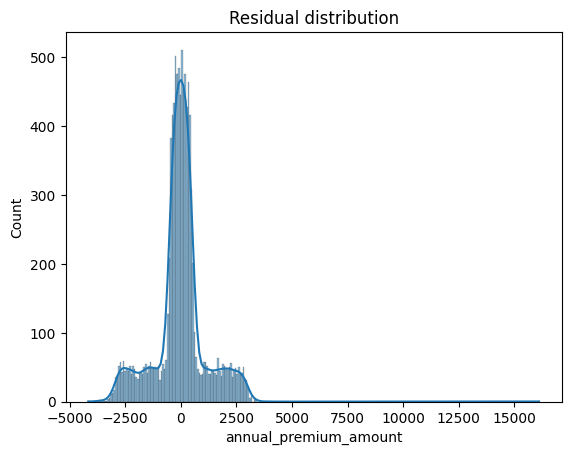

In [7]:
resid = y_test - y_pred_test
sns.histplot(resid, kde=True)
plt.title("Residual distribution")
plt.show()


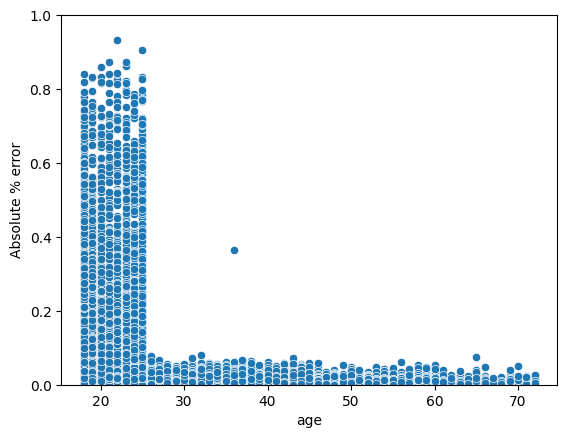

In [8]:
sns.scatterplot(x=df["age"], y=np.abs(resid)/y_test)
plt.ylim(0, 1)
plt.ylabel("Absolute % error")
plt.show()


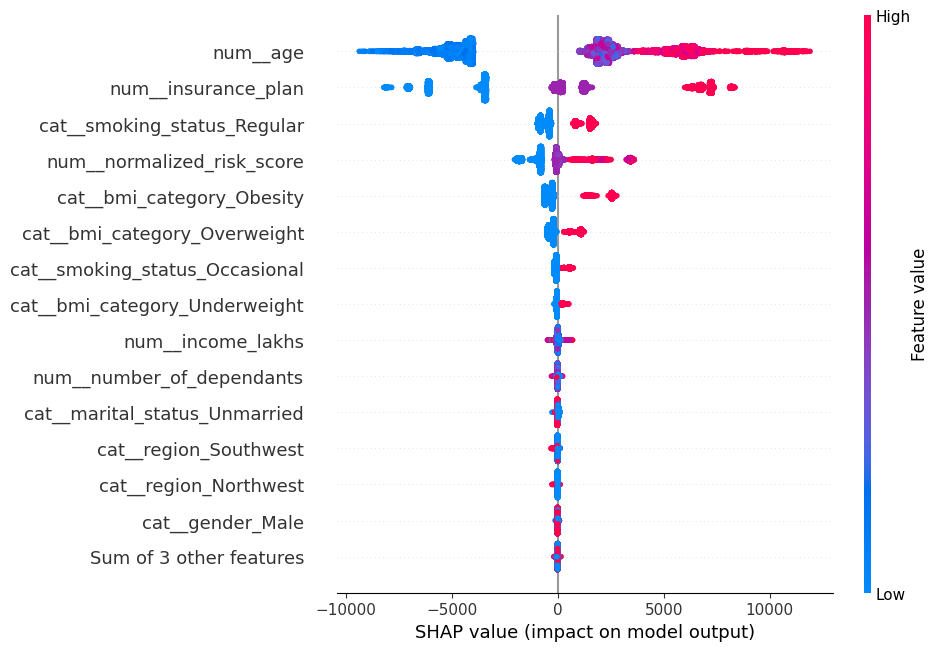

In [9]:
import shap
feat_names = model_xgb.named_steps["prep"].get_feature_names_out()
expl = shap.TreeExplainer(model_xgb.named_steps["model"])
X_enc = model_xgb.named_steps["prep"].transform(X)
sh_values = expl(X_enc, check_additivity=False)
sh_values.feature_names = feat_names
shap.plots.beeswarm(sh_values, max_display=15)


### Residuals Dataframe

In [10]:
resid = y_test - y_pred_test
resid_pct = resid * 100 / y_test

results_df = pd.DataFrame({
    "acutals" : y_test,
    "predicted" : y_pred_test,
    'diff' : resid,
    "diff_pct" : resid_pct
})
results_df = results_df.round(2)
results_df.head()

,acutals,predicted,diff,diff_pct
8194,26776,27078.720703,-302.72,-1.13
34140,23086,23110.519531,-24.53,-0.11
38517,6812,7013.149902,-201.15,-2.95
48608,22998,22597.710938,400.29,1.74
35605,7729,6980.680176,748.32,9.68


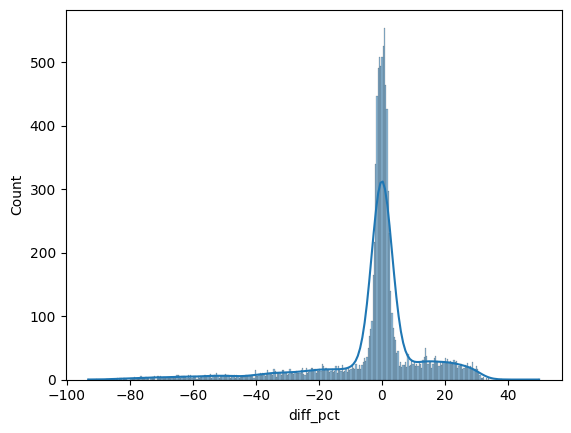

In [11]:
sns.histplot(results_df["diff_pct"], kde=True)
plt.show()

In [12]:
results_df.sort_values(by="diff_pct")

,acutals,predicted,diff,diff_pct
23943,3520,6801.410156,-3281.41,-93.22
36688,3549,6766.609863,-3217.61,-90.66
21257,3627,6794.259766,-3167.26,-87.32
25665,3615,6768.770020,-3153.77,-87.24
18896,3502,6518.109863,-3016.11,-86.13
...,...,...,...,...
38835,9618,6409.779785,3208.21,33.36
19550,10000,6595.100098,3404.90,34.05
7789,9933,6541.450195,3391.55,34.14
20850,10593,6595.680176,3997.32,37.74


In [13]:
extreme_error_threshold = 10

extreme_results_df = results_df[np.abs(results_df["diff_pct"]) > extreme_error_threshold]#higher than 10% diff both sides
extreme_results_df.shape, results_df.shape

((2867, 4), (9991, 4))

In [14]:
pct_extreme_errors = extreme_results_df.shape[0]*100 / results_df.shape[0]
pct_extreme_errors

## 28% of errors are extreme ones(more than 10%)

28.69582624361926

#### Finding the root cause of margin errors

In [15]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_lakhs,medical_history,insurance_plan,disease1,disease2,total_risk_score,normalized_risk_score
46295,22,Male,Southwest,Unmarried,0,Overweight,No Smoking,Salaried,3,High blood pressure,1,high blood pressure,none,6,0.428571
40511,18,Female,Southeast,Unmarried,0,Underweight,No Smoking,Self-Employed,18,Diabetes & Heart disease,1,diabetes,heart disease,14,1.000000
13641,24,Male,Southwest,Married,3,Normal,Regular,Freelancer,22,No Disease,2,no disease,none,0,0.000000
879,24,Male,Southwest,Unmarried,0,Normal,Regular,Salaried,11,No Disease,1,no disease,none,0,0.000000
1640,22,Female,Southeast,Unmarried,0,Overweight,No Smoking,Salaried,1,No Disease,1,no disease,none,0,0.000000


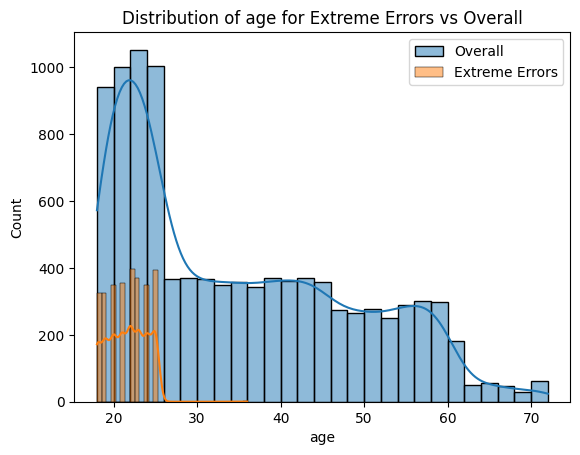

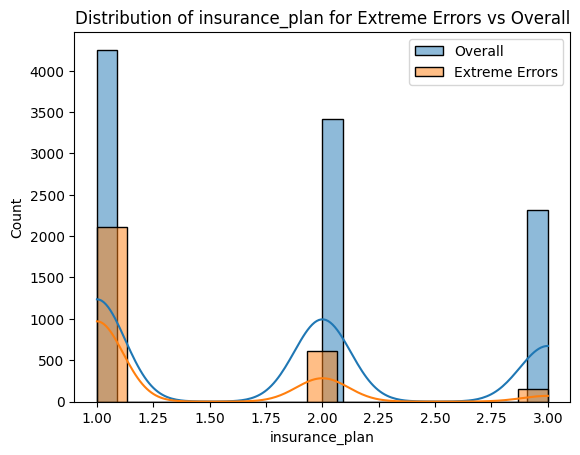

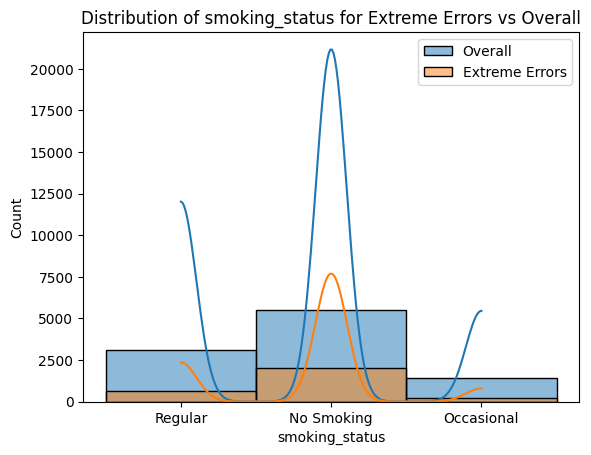

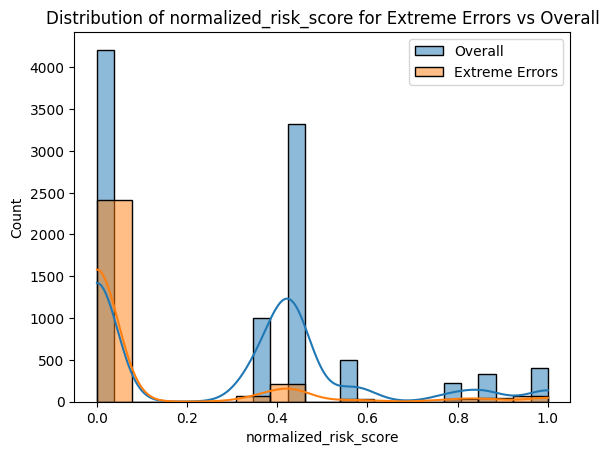

In [16]:
cols_to_viz = ["age", "insurance_plan", "smoking_status", "normalized_risk_score"] #based on scores from SHAP plot

for col in cols_to_viz:
    sns.histplot(X_test[col], kde=True, label="Overall")
    sns.histplot(extreme_errors_df[col], kde=True, label="Extreme Errors")
    plt.legend()
    plt.title(f"Distribution of {col} for Extreme Errors vs Overall")
    plt.show()


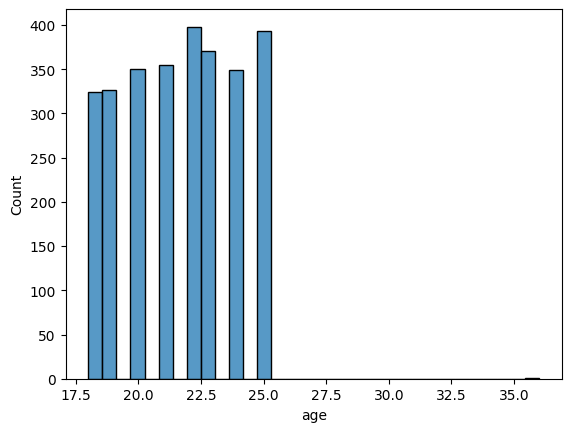

In [17]:
sns.histplot(extreme_errors_df["age"])
plt.show()

In [18]:
extreme_errors_df["age"].quantile(0.99)

np.float64(25.0)

In [19]:
df["age"].describe()

count    49953.000000
mean        34.401577
std         13.680203
min         18.000000
25%         22.000000
50%         31.000000
75%         45.000000
max         72.000000
Name: age, dtype: float64

In [20]:
extreme_errors_df["age"].describe()

count    2867.000000
mean       21.627834
std         2.285906
min        18.000000
25%        20.000000
50%        22.000000
75%        24.000000
max        36.000000
Name: age, dtype: float64

### Conclusion
#### I can clearly observe, that the only distribution error(meaning the plots aren't shaped in a similar way) in in the "age" column, since most extreme errors occur between ages 18-25